## This is the newest version of EBM analysis, which includes a simplified APRP analysis for shortwave analysis,
## and the separation of greenhouse gases and clouds induced emissivity changes, as well as the separation of 
## ocean heat flux from atmosphere heat flux

## EBM

In [61]:
# This is a good version to create the anomalies to the PI control expt.
# This is the python version of energy balance model
# original script of Dan's is here:
# /home/bridge/ggdjl/ggdjl/bas/doc/eocene_deepmip/analysis/fluxes.pro
# Simplified version of Alex's is here:
# /home/bridge/nd20983/scripts/make_EBM_fluxes_alex.pro
# ====================================================================
# ENERGY BALANCE MODEL
# ====================================================================

import numpy as np
import numpy.ma as ma
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import math
import string


# constants used
sigma = 5.67e-8
# dataarrays for simulations
nmodel = 1
nsims = 13
model_name = ['HadCM3BL']
#DataArray = ['xpeca1', 'xpecb1', 'xpecc1', 'xpgxa', 'xpgxb', 'xpgxc', 'xphaa',
#             'xphab', 'xphac']
DataArray = ['xpeca1', 'xpecb1', 'xpecc1', 'tflha', 'xpgxa', 'xpgxb', 'xpgxc',
             'tflhc', 'xphaa', 'xphab', 'xphac', 'tflhd', 'tdezb1']
#geo_stages = ['ser_get', 'ser_get', 'ser_get', 'ser_sco', 'ser_sco', 'ser_sco',
#              'ser_robo', 'ser_robo', 'ser_robo']
geo_stages = ['ser_get', 'ser_sco', 'ser_robo', 'ser_hero', 'ser_get', 'ser_sco',
              'ser_robo', 'ser_hero', 'ser_get', 'ser_sco', 'ser_robo', 'ser_hero']
#stages_name = ['1xCO2', '1xCO2', '1xCO2', '2xCO2', '2xCO2', '2xCO2', '3xCO2',
#               '3xCO2', '3xCO2', ]
stages_name = ['1xCO2', '1xCO2', '1xCO2', '1XCO2', '2xCO2', '2xCO2', '2xCO2',
               '2xCO2', '3xCO2', '3xCO2', '3xCO2', '3xCO2']
#co2_name = ['Get_280ppm', 'Sco_280ppm', 'Robo_280ppm', 'Get_560ppm',
#            'Sco_560ppm', 'Robo_560ppm', 'Get_840ppm', 'Sco_840ppm',
#            'Robo_840ppm']
co2_name = ['Get_280ppm', 'Sco_280ppm', 'Robo_280ppm', 'Hero_280ppm', 'Get_560ppm',
            'Sco_560ppm', 'Robo_560ppm', 'Hero_280ppm', 'Get_840ppm', 'Sco_840ppm',
            'Robo_840ppm', 'Hero_840ppm']
varshortname = ['ts', 'rlus', 'rlds', 'rsus', 'rsds', 'rlut', 'rsut', 'rsdt',
                'netLWsrf', 'netSWsrf','rsutcs','rlutcs','shf','lhf',]
varname = ['temp_mm_1_5m',
           'ilr_mm_s3_srf',
           'solar_mm_s3_srf',
           'downSol_Seaice_mm_s3_srf',
           'olr_mm_s3_TOA',
           'upSol_mm_s3_TOA',
           'downSol_mm_TOA',
           'longwave_mm_s3_srf',
           'clrskyUpSol_mm_s3_TOA',
           'csolr_mm_s3_TOA',
           'sh_mm_hyb',
           'lh_mm_srf',
           ]
dervar_2d_shortname = ['als', 'alt', 'tsm', 'tsd', 'emm', 'htr', 'sol',
                       'clralt','clremi','clrhtr','ocnhtr','atmhtr',]
dervar_2d_name = ['Surface albedo',
                  'TOA albedo',
                  'Surface temperature',
                  'Derived surface temperature',
                  'Emissivity',
                  'Heat transport',
                  'Solar radiation',
                  'clr albedo',
                  'clr emissivity',
                  'clr heat transport',
                  'ocn heat transport',
                  'atm heat transport',
                  ]
dervar_2d_unit = ['[0-1]', '[0-1]', '[K]', '[K]', '[0-1]', 'W/m2',
                  '[0-1]', '[0-1]', 'W/m2', 'W/m2', 'W/m2']
# Following ebm variables represent the estimation of the contributions of various
# components to the temperature change, the last three components (reverse) is 
# currently not in use. We may need to add the clear sky components later.
ebmvar_name = ['temp change (GCM)',
               'temp change (EBM)',
               'temp albedo',
               'temp emissivity',
               'temp heat transport',
               'temp solar',
               'temp change (sum)',
               'temp albedo (surface)',
               'temp albedo (non-surface)',
               'temp albedo (surf, arsl)',
               'temp albedo (cloud)',
               'temp emissivity (gg)',
               'temp emissivity (cloud)',
               'temp ocn heat transport',
               'temp atm heat transport',
               ]
ebmvarlpw_name, ebmvarllpw_name, ebmvarhnlpw_name, ebmvarhslpw_name = [], [], [], []
for i in ebmvar_name:
    ebmvarlpw_name.append('lpw '+i)
    ebmvarllpw_name.append('llpw '+i)
    ebmvarhnlpw_name.append('hnlpw '+i)
    ebmvarhslpw_name.append('hslpw '+i)
#=====================================================================================================================
#=====================================================================================================================
# variables need to be plotted, we'll add more later
var_plots = ['ebm0','ebm1','ebm2','ebm3','ebm4','ebm5','ebm6','ebm7','ebm8','ebm9','ebm10','ebm11','ebm12','ebm13','ebm14']
sim_dict, var_dict = {}, {}
sim_dict2, var_dict2, ebm_dict = {}, {}, {}
# ===============================================================================
# 1.  ts = temp_mm_1_5m                     # 1.5m air temperature
# 2.  rlus = ilr_mm_s3_srf - longwave_mm_s3_srf 
                                         # Surface upwelling LW Rad. (Downwelling LW Rad. Flux Surface minus Net Down Surface LW Flux: LW TS only.)
# 3.  rlds = ilr_mm_s3_srf                 # Downwelling LW Rad. Flux Surface
# 4.  rsus = downSol_Seaice_mm_s3_srf - solar_mm_s3_srf
#                                         # Surface upwelling SW Rad. (Total Downward Surface SW Flux minus Net Down Surface SW Flux. SW TS only.)
# 5.  rsds = downSol_Seaice_mm_s3_srf    # Total Downward Surface SW Flux
# 6.  rlut = olr_mm_s3_TOA                 # TOA outgoing LW Rad.
# 7.  rsut = upSol_mm_s3_TOA                 # TOA outgoing SW Rad.
# 8.  rsdt = downSol_mm_TOA                 # TOA incident SW Rad.
# 9.  netLWsrf = longwave_mm_s3_srf         # Net LW Rad. Surface
# 10. netSWsrf = solar_mm_s3_srf         # Net SW Rad. Surface
# 11. rsutcs = clrskyUpSol_mm_s3_TOA     # clear-sky TOA outgoing SW flux
# 12. rlutcs = csolr_mm_s3_TOA           # clear-sky TOA outgoing LW flux
# 13. shf = sh_mm_hyb                    # sensible heat flux
# 14. lhf = lh_mm_srf                    # latent heat flux
# 15. 
# ===============================================================================
lsm_low_loc, lsm_high_loc, sim_loc = [], [], []
sim_adr='C:/Users/nd20983/docs/Simulations/data/rawdata/'
for i in range(nsims):
    sim_loc.append(sim_adr+DataArray[i]+'a.pdclann.nc')
lsm_low, lsm_high = [], []
topo_low, topo_high = [], []
lon_constant = 96
lat_constant = 73
lons, lats = [], []
lons_lsm, lats_lsm = [], []
lons_topo, lats_topo = [], []

# Get the boundaries of lats and lons
dlon = 360/lon_constant
dlat = 180/(lat_constant-1)
origin = 0
lons_m, lats_m = [], []
lonsedge_m, latsedge_m = [], []

for i in range(lon_constant):
    lons_m.append(dlon*i + origin)
    lonsedge_m.append(dlon*i + origin - dlon/2.0)
lonsedge_m.append(lonsedge_m[-1] + dlon)

latsedge_m = [90]
for j in range(lat_constant-1):
    latsedge_m.append(90 - dlat/2.0 - dlat*j)
latsedge_m.append(-90)
for n in range(len(latsedge_m)-1):
    lats_m.append((latsedge_m[n] + latsedge_m[n+1])/2.0)

# Calculate the latitudinal partial weight
# Latitudinal partially weighted 
weight_lat_temp, weight_lat = [], []
for i in range(lat_constant):
    weight_lat_temp.append(-(np.sin(latsedge_m[i+1]*2*np.pi/360.0) - np.sin(latsedge_m[i]*2*np.pi/360.0)))
for i in range(lat_constant):
    weight_lat.append(weight_lat_temp[i]/sum(weight_lat_temp))

# Get the mask for different zones
lats_hs = ma.masked_greater(lats_m, -60)
lats_hn = ma.masked_less(lats_m, 60)
lats_l = ma.masked_outside(lats_m, -30, 30)

#=====================================================================================================================
#=====================================================================================================================
# Define what's in the plots
#make_mapplots = [True, True, False, True, True, False, False, True, True]
make_mapplots = [True,True,False,False,False,False,False,False,False,True,True,True,True,True,True,]

# ===============================================================================
# LOAD LAND SEA MASKS
# ===============================================================================


for m in range(nsims):
    ebm_dict[DataArray[m]] = {}
#    data_lsm_low = nc.Dataset(lsm_low_loc[m], mode='r')
# Note the lsm does not hold variables 'longitude' and 'latitude'
#    lons_lsm[m], lats_lsm[m] = np.meshgrid(lsm_low[m]['longitude'],
#                                           lsm_low[m]['latitude'])
    data_sim = nc.Dataset(sim_loc[m], mode='r')
# ===============================================================================
# read basic variables
# ===============================================================================
    sim_dict[m] = var_dict
    var_dict['ts'] = data_sim.variables[varname[0]][:]-273.15
    var_dict['rlus'] = data_sim.variables[varname[1]][:]-data_sim.variables[varname[7]][:]
    var_dict['rsus'] = data_sim.variables[varname[3]][:]-data_sim.variables[varname[2]][:]
    var_dict['rlds'] = data_sim.variables[varname[1]][:]
    var_dict['rsds'] = data_sim.variables[varname[3]][:]
    var_dict['rlut'] = data_sim.variables[varname[4]][:]
    var_dict['rsut'] = data_sim.variables[varname[5]][:]
    var_dict['rsdt'] = data_sim.variables[varname[6]][:]
    var_dict['netLWsrf'] = data_sim.variables[varname[7]][:]
    var_dict['netSWsrf'] = data_sim.variables[varname[2]][:]
    var_dict['rsutcs'] = data_sim.variables[varname[8]][:]
    var_dict['rlutcs'] = data_sim.variables[varname[9]][:]
    var_dict['shf'] = data_sim.variables[varname[10]][:]
    var_dict['lhf'] = data_sim.variables[varname[11]][:]
    
# ===============================================================================
# get the derived variables
# ===============================================================================
    var_dict['tsm'] = var_dict['ts']
    var_dict['tsd'] = (var_dict['rlus']/sigma)**(0.25)-273.15
    var_dict['als'] = var_dict['rsus']/var_dict['rsds']
    var_dict['alt'] = var_dict['rsut']/var_dict['rsdt']
    var_dict['emm'] = var_dict['rlut']/var_dict['rlus']
    var_dict['htr'] = var_dict['rlut']+var_dict['rsut']-var_dict['rsdt']
    var_dict['sol'] = var_dict['rsdt']
    var_dict['albcs'] = var_dict['rsutcs']/var_dict['rsdt']
    var_dict['emics'] = var_dict['rlutcs']/var_dict['rlus']
    var_dict['htrcs'] = var_dict['rlutcs']+var_dict['rsutcs']-var_dict['rsdt']
    var_dict['htrocn'] = var_dict['shf']+var_dict['lhf']-(var_dict['netLWsrf']+var_dict['netSWsrf'])
    var_dict['htratm'] = var_dict['htr']-var_dict['htrocn']
    
# ===============================================================================
# define zonal mean variables
# get the zonal mean
# ===============================================================================
    var_dict['zmts'] = np.mean(var_dict['ts'][0, 0, :, :], axis=1)
    var_dict['zmrlds'] = np.mean(var_dict['rlds'][0, 0, :, :], axis=1)
    var_dict['zmrsds'] = np.mean(var_dict['rsds'][0, 0, :, :], axis=1)
    var_dict['zmrsut'] = np.mean(var_dict['rsut'][0, 0, :, :], axis=1)
    var_dict['zmrsdt'] = np.mean(var_dict['rsdt'][0, 0, :, :], axis=1)
    var_dict['zmrlut'] = np.mean(var_dict['rlut'][0, 0, :, :], axis=1)
    var_dict['zmrlus'] = np.mean(var_dict['rlus'][0, 0, :, :], axis=1)
    var_dict['zmrsus'] = np.mean(var_dict['rsus'][0, 0, :, :], axis=1)
    var_dict['zmnetLWsrf'] = np.mean(var_dict['netLWsrf'][0, 0, :, :], axis=1)
    var_dict['zmnetSWsrf'] = np.mean(var_dict['netSWsrf'][0, 0, :, :], axis=1)
    var_dict['zmrsutcs'] = np.mean(var_dict['rsutcs'][0, 0, :, :], axis=1)
    var_dict['zmrlutcs'] = np.mean(var_dict['rlutcs'][0, 0, :, :], axis=1)
    var_dict['zmshf'] = np.mean(var_dict['shf'][0, 0, :, :], axis=1)
    var_dict['zmlhf'] = np.mean(var_dict['lhf'][0, 0, :, :], axis=1)
#
    var_dict['zmtsm'] = (var_dict['zmts'])
    var_dict['zmtsd'] = (var_dict['zmrlus']/sigma)**(0.25)-273.15
    var_dict['zmals'] = (var_dict['zmrsus'])/(var_dict['zmrsds'])
    var_dict['zmalt'] = (var_dict['zmrsut'])/(var_dict['zmrsdt'])
    var_dict['zmemm'] = (var_dict['zmrlut'])/(var_dict['zmrlus'])
    var_dict['zmhtr'] = (var_dict['zmrlut'])+(var_dict['zmrsut'])+(var_dict['zmrsdt'])
    var_dict['zmsol'] = (var_dict['zmrsdt'])
    var_dict['zmalbcs'] = (var_dict['zmrsutcs'])/(var_dict['zmrsdt'])
    var_dict['zmemics'] = (var_dict['zmrlutcs'])/(var_dict['zmrlus'])
    var_dict['zmhtrcs'] = (var_dict['zmrlutcs'])+(var_dict['zmrsutcs'])-(var_dict['zmrsdt'])
    var_dict['zmhtrocn'] = var_dict['zmshf']+var_dict['zmlhf']-(var_dict['zmnetLWsrf']+var_dict['zmnetSWsrf'])
    var_dict['zmhtratm'] = var_dict['zmhtr']-var_dict['zmhtrocn']

    # Save useful data to ebm_dict
    ebm_dict[DataArray[m]]['zmtsm'] = var_dict['zmtsm']
    ebm_dict[DataArray[m]]['zmtsd'] = var_dict['zmtsd']
    ebm_dict[DataArray[m]]['zmals'] = var_dict['zmals']
    ebm_dict[DataArray[m]]['zmalt'] = var_dict['zmalt']
    ebm_dict[DataArray[m]]['zmemm'] = var_dict['zmemm']
    ebm_dict[DataArray[m]]['zmhtr'] = var_dict['zmhtr']
    ebm_dict[DataArray[m]]['zmalbcs'] = var_dict['zmalbcs']
    ebm_dict[DataArray[m]]['zmemics'] = var_dict['zmemics']
    ebm_dict[DataArray[m]]['zmhtrcs'] = var_dict['zmhtrcs']
    ebm_dict[DataArray[m]]['zmhtrocn'] = var_dict['zmhtrocn']
    ebm_dict[DataArray[m]]['zmhtratm'] = var_dict['zmhtratm']
    
# ===============================================================================
# alright, make some zomal mean plots
# ===============================================================================
#    fig = plt.figure(num=DataArray[m], figsize=(12, 6), dpi=100)
    lons, lats = np.meshgrid(data_sim['longitude'], data_sim['latitude'])
    ebm_dict[DataArray[m]]['zmlats'] = np.mean(lats[:,:], axis=1)
#    ax = fig.add_subplot(3,3,m+1)
#    zmtsm_p = ax.plot(zmlats, var_dict['zmtsm'], c='red', marker='.')
#    zmtsd_p = ax.plot(zmlats, var_dict['zmtsd'], c='tomato', marker='x')
#    zmals_p = ax.plot(zmlats, var_dict['zmals'], c='blue', marker='.')
#    zmalt_p = ax.plot(zmlats, var_dict['zmalt'], c='black', marker='x')
#    zmemm_p = ax.plot(zmlats, var_dict['zmemm'], c='orange', marker='x')
#    zmhtr_p = plt.plot(zmlats, var_dict['zmhtr'], c='slategray', marker='x')
# now make it a figure
#    ax.set_title('Latitudinal basics of '+DataArray[m])
# ===============================================================================
# make some difference plots
# ===============================================================================
    for mm in range(nsims):
        if mm != m:
            ebm_dict[DataArray[m]][DataArray[mm]] = {}
            data_sim2 = nc.Dataset(sim_loc[mm], mode='r')
            sim_dict2 = var_dict2
#
            var_dict2['ts'] = data_sim2.variables[varname[0]][:]-273.15
            var_dict2['rlus'] = data_sim2.variables[varname[1]][:]-data_sim2.variables[varname[7]][:]
            var_dict2['rsus'] = data_sim2.variables[varname[3]][:]-data_sim2.variables[varname[2]][:]
            var_dict2['rlds'] = data_sim2.variables[varname[1]][:]
            var_dict2['rsds'] = data_sim2.variables[varname[3]][:]
            var_dict2['rlut'] = data_sim2.variables[varname[4]][:]
            var_dict2['rsut'] = data_sim2.variables[varname[5]][:]
            var_dict2['rsdt'] = data_sim2.variables[varname[6]][:]
            var_dict2['netLWsrf'] = data_sim2.variables[varname[7]][:]
            var_dict2['netSWsrf'] = data_sim2.variables[varname[2]][:]
            var_dict2['rsutcs'] = data_sim2.variables[varname[8]][:]
            var_dict2['rlutcs'] = data_sim2.variables[varname[9]][:]
            var_dict2['shf'] = data_sim2.variables[varname[10]][:]
            var_dict2['lhf'] = data_sim2.variables[varname[11]][:]
#
            var_dict2['tsm'] = var_dict2['ts']
            var_dict2['tsd'] = (var_dict2['rlus']/sigma)**(0.25)-273.15
            var_dict2['als'] = var_dict2['rsus']/var_dict2['rsds']
            var_dict2['alt'] = var_dict2['rsut']/var_dict2['rsdt']
            var_dict2['emm'] = var_dict2['rlut']/var_dict2['rlus']
            var_dict2['htr'] = var_dict2['rlut']+var_dict2['rsut']-var_dict2['rsdt']
            var_dict2['sol'] = var_dict2['rsdt']
            var_dict2['albcs'] = var_dict2['rsutcs']/var_dict2['rsdt']
            var_dict2['emics'] = var_dict2['rlutcs']/var_dict2['rlus']
            var_dict2['htrcs'] = var_dict2['rlutcs']+var_dict2['rsutcs']-var_dict2['rsdt']
            var_dict2['htrocn'] = var_dict2['shf']+var_dict2['lhf']-(var_dict2['netLWsrf']+var_dict2['netSWsrf'])
            var_dict2['htratm'] = var_dict2['htr']-var_dict2['htrocn']
#
            var_dict2['zmts'] = np.mean(var_dict2['ts'][0, 0, :, :], axis=1)
            var_dict2['zmrlds'] = np.mean(var_dict2['rlds'][0, 0, :, :], axis=1)
            var_dict2['zmrsds'] = np.mean(var_dict2['rsds'][0, 0, :, :], axis=1)
            var_dict2['zmrsut'] = np.mean(var_dict2['rsut'][0, 0, :, :], axis=1)
            var_dict2['zmrsdt'] = np.mean(var_dict2['rsdt'][0, 0, :, :], axis=1)
            var_dict2['zmrlut'] = np.mean(var_dict2['rlut'][0, 0, :, :], axis=1)
            var_dict2['zmrlus'] = np.mean(var_dict2['rlus'][0, 0, :, :], axis=1)
            var_dict2['zmrsus'] = np.mean(var_dict2['rsus'][0, 0, :, :], axis=1)
            var_dict2['zmnetLWsrf'] = np.mean(var_dict2['netLWsrf'][0, 0, :, :], axis=1)
            var_dict2['zmnetSWsrf'] = np.mean(var_dict2['netSWsrf'][0, 0, :, :], axis=1)
            var_dict2['zmrsutcs'] = np.mean(var_dict2['rsutcs'][0, 0, :, :], axis=1)
            var_dict2['zmrlutcs'] = np.mean(var_dict2['rlutcs'][0, 0, :, :], axis=1)
            var_dict2['zmshf'] = np.mean(var_dict2['shf'][0, 0, :, :], axis=1)
            var_dict2['zmlhf'] = np.mean(var_dict2['lhf'][0, 0, :, :], axis=1)
#            
            var_dict2['zmtsm'] = (var_dict2['zmts'])
            var_dict2['zmtsd'] = (var_dict2['zmrlus']/sigma)**(0.25)-273.15
            var_dict2['zmals'] = (var_dict2['zmrsus'])/(var_dict2['zmrsds'])
            var_dict2['zmalt'] = (var_dict2['zmrsut'])/(var_dict2['zmrsdt'])
            var_dict2['zmemm'] = (var_dict2['zmrlut'])/(var_dict2['zmrlus'])
            var_dict2['zmhtr'] = (var_dict2['zmrlut'])+(var_dict2['zmrsut'])+(var_dict2['zmrsdt'])
            var_dict2['zmsol'] = (var_dict2['zmrsdt'])
            var_dict2['zmalbcs'] = (var_dict2['zmrsutcs'])/(var_dict2['zmrsdt'])
            var_dict2['zmemics'] = (var_dict2['zmrlutcs'])/(var_dict2['zmrlus'])
            var_dict2['zmhtrcs'] = (var_dict2['zmrlutcs'])+(var_dict2['zmrsutcs'])-(var_dict2['zmrsdt'])
            var_dict2['zmhtrocn'] = var_dict2['zmshf']+var_dict2['zmlhf']-(var_dict2['zmnetLWsrf']+var_dict2['zmnetSWsrf'])
            var_dict2['zmhtratm'] = var_dict2['zmhtr']-var_dict2['zmhtrocn']
# ===============================================================================
# Now calculate EBM components
# ===============================================================================
            albs1 = var_dict['zmals']
            albt1 = var_dict['zmalt']
            emmi1 = var_dict['zmemm']
            htra1 = var_dict['zmhtr']
            sola1 = var_dict['zmsol']
            temp1 = var_dict['zmtsm']
            tempebm1 = (1.0/(emmi1*sigma)*(sola1*(1-albt1)+htra1))**0.25-273.15
            albcs1 = var_dict['zmalbcs']
            emics1 = var_dict['zmemics']
            htrcs1 = var_dict['zmhtrcs']
            htrocn1 = var_dict['zmhtrocn']
            htratm1 = var_dict['zmhtratm']
            tempebm1cs = (1.0/(emics1*sigma)*(sola1*(1-albcs1)+htrcs1))**0.25-273.15
#
            albs2 = var_dict2['zmals']
            albt2 = var_dict2['zmalt']
            emmi2 = var_dict2['zmemm']
            htra2 = var_dict2['zmhtr']
            sola2 = var_dict2['zmsol']
            temp2 = var_dict2['zmtsm']
            tempebm2 = (1.0/(emmi2*sigma)*(sola2*(1-albt2)+htra2))**0.25-273.15
            albcs2 = var_dict2['zmalbcs']
            emics2 = var_dict2['zmemics']
            htrcs2 = var_dict2['zmhtrcs']
            htrocn2 = var_dict2['zmhtrocn']
            htratm2 = var_dict2['zmhtratm']
            tempebm2cs = (1.0/(emics2*sigma)*(sola2*(1-albcs2)+htrcs2))**0.25-273.15
#
# OK, this is the surface component
#            tempebm1albs2 = (1.0/(emmi1*sigma)*(sola1*(1-(albt1+(albs2-albs1)))+htra1))**0.25-273.15
#
#            tempebm1albt2 = (1.0/(emmi1*sigma)*(sola1*(1-albt2)+htra1))**0.25-273.15
#            tempebm1emmi2 = (1.0/(emmi2*sigma)*(sola1*(1-albt1)+htra1))**0.25-273.15
#            tempebm1htra2 = (1.0/(emmi1*sigma)*(sola1*(1-albt1)+htra2))**0.25-273.15
#            tempebm1sola2 = (1.0/(emmi1*sigma)*(sola2*(1-albt1)+htra1))**0.25-273.15
#
# OK, this is the surface component
            # we gonna calculate the surface albedo component in another way, but for now keep this as a comparison
            tempebm2albs1 = (1.0/(emmi2*sigma)*(sola2*(1-(albt2+(albs1-albs2)))+htra2))**0.25-273.15
#
            tempebm2albt1 = (1.0/(emmi2*sigma)*(sola2*(1-albt1)+htra2))**0.25-273.15
            tempebm2emmi1 = (1.0/(emmi1*sigma)*(sola2*(1-albt2)+htra2))**0.25-273.15
            tempebm2htra1 = (1.0/(emmi2*sigma)*(sola2*(1-albt2)+htra1))**0.25-273.15
            tempebm2sola1 = (1.0/(emmi2*sigma)*(sola1*(1-albt2)+htra2))**0.25-273.15
            # for heat transport separation
            tempebm2htrocn1 = (1.0/(emmi2*sigma)*(sola2*(1-albt2)+(htrocn1+htratm2)))**0.25-273.15
            # for clear-sky components
            tempebm2csalbcs1 = (1.0/(emics2*sigma)*(sola2*(1-albcs1)+htrcs2))**0.25-273.15
            tempebm2csemics1 = (1.0/(emics1*sigma)*(sola2*(1-albcs2)+htrcs2))**0.25-273.15
#
# Get the latitudinal partially weighted values
            lpw_temp1 = temp1*weight_lat
            lpw_temp2 = temp2*weight_lat
            lpw_tempebm1 = tempebm1*weight_lat
            lpw_tempebm2 = tempebm2*weight_lat
            lpw_tempebm1albs2 = tempebm1albs2*weight_lat
            lpw_tempebm1albt2 = tempebm1albt2*weight_lat
            lpw_tempebm1emmi2 = tempebm1emmi2*weight_lat
            lpw_tempebm1htra2 = tempebm1htra2*weight_lat
            lpw_tempebm1sola2 = tempebm1sola2*weight_lat
            lpw_tempebm2albs1 = tempebm2albs1*weight_lat
            lpw_tempebm2albt1 = tempebm2albt1*weight_lat
            lpw_tempebm2emmi1 = tempebm2emmi1*weight_lat
            lpw_tempebm2htra1 = tempebm2htra1*weight_lat
            lpw_tempebm2sola1 = tempebm2sola1*weight_lat
            lpw_tempebm2cs = tempebm2cs*weight_lat
            lpw_tempebm2htrocn1 = tempebm2htrocn1*weight_lat
            lpw_tempebm2csalbcs1 = tempebm2csalbcs1*weight_lat
            lpw_tempebm2csemics1 = tempebm2csemics1*weight_lat
# Save data to the output dict
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[0]] = -(temp1-temp2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[1]] = -(tempebm1-tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[2]] = -(tempebm2albt1-tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[3]] = -(tempebm2emmi1-tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[4]] = -(tempebm2htra1-tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[5]] = -(tempebm2sola1-tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[6]] = -(tempebm2albt1-tempebm2+tempebm2emmi1-tempebm2+tempebm2htra1-tempebm2+tempebm2sola1-tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[7]] = -(tempebm2albs1-tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[8]] = -(tempebm2albt1-tempebm2albs1)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[9]] = -(tempebm2csalbcs1-tempebm2cs)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[10]] = (ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[2]]\
                                                                        -ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[9]])
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[11]] = -(tempebm2csemics1-tempebm2cs)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[12]] = (ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[3]]\
                                                                        -ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[11]])
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[13]] = -(tempebm2htrocn1-tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[14]] = (ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[4]]\
                                                                     -ebm_dict[DataArray[m]][DataArray[mm]][ebmvar_name[13]])
#            
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[0]] = -(lpw_temp1-lpw_temp2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[1]] = -(lpw_tempebm1-lpw_tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[2]] = -(lpw_tempebm2albt1-lpw_tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[3]] = -(lpw_tempebm2emmi1-lpw_tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[4]] = -(lpw_tempebm2htra1-lpw_tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[5]] = -(lpw_tempebm2sola1-lpw_tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[6]] = -(lpw_tempebm2albt1-lpw_tempebm2+lpw_tempebm2emmi1-lpw_tempebm2+lpw_tempebm2htra1-lpw_tempebm2+lpw_tempebm2sola1-lpw_tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[7]] = -(lpw_tempebm2albs1-lpw_tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[8]] = -(lpw_tempebm2albt1-lpw_tempebm2albs1)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[9]] = -(lpw_tempebm2csalbcs1-lpw_tempebm2cs)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[10]] = (ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[2]]\
                                                                         -ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[9]])
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[11]] = -(lpw_tempebm2csemics1-lpw_tempebm2cs)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[12]] = (ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[3]]\
                                                                         -ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[11]])
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[13]] = -(lpw_tempebm2htrocn1-lpw_tempebm2)
            ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[14]] = (ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[4]]\
                                                                        -ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[13]])
            
#            
            for i in range(len(ebmvar_name)):
                ebm_dict[DataArray[m]][DataArray[mm]][ebmvarllpw_name[i]] = ma.masked_array(ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[i]],
                                                                                            mask = ma.getmask(lats_l)
                                                                                            )
                ebm_dict[DataArray[m]][DataArray[mm]][ebmvarhnlpw_name[i]] = ma.masked_array(ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[i]],
                                                                                            mask = ma.getmask(lats_hn)
                                                                                            )
                ebm_dict[DataArray[m]][DataArray[mm]][ebmvarhslpw_name[i]] = ma.masked_array(ebm_dict[DataArray[m]][DataArray[mm]][ebmvarlpw_name[i]],
                                                                                            mask = ma.getmask(lats_hs)
                                                                                            )
        else:
            pass
# now close the data read
    data_sim2.close()
data_sim.close()
#data_lsm_low.close()


## Figure: anomalies to pre-industrial

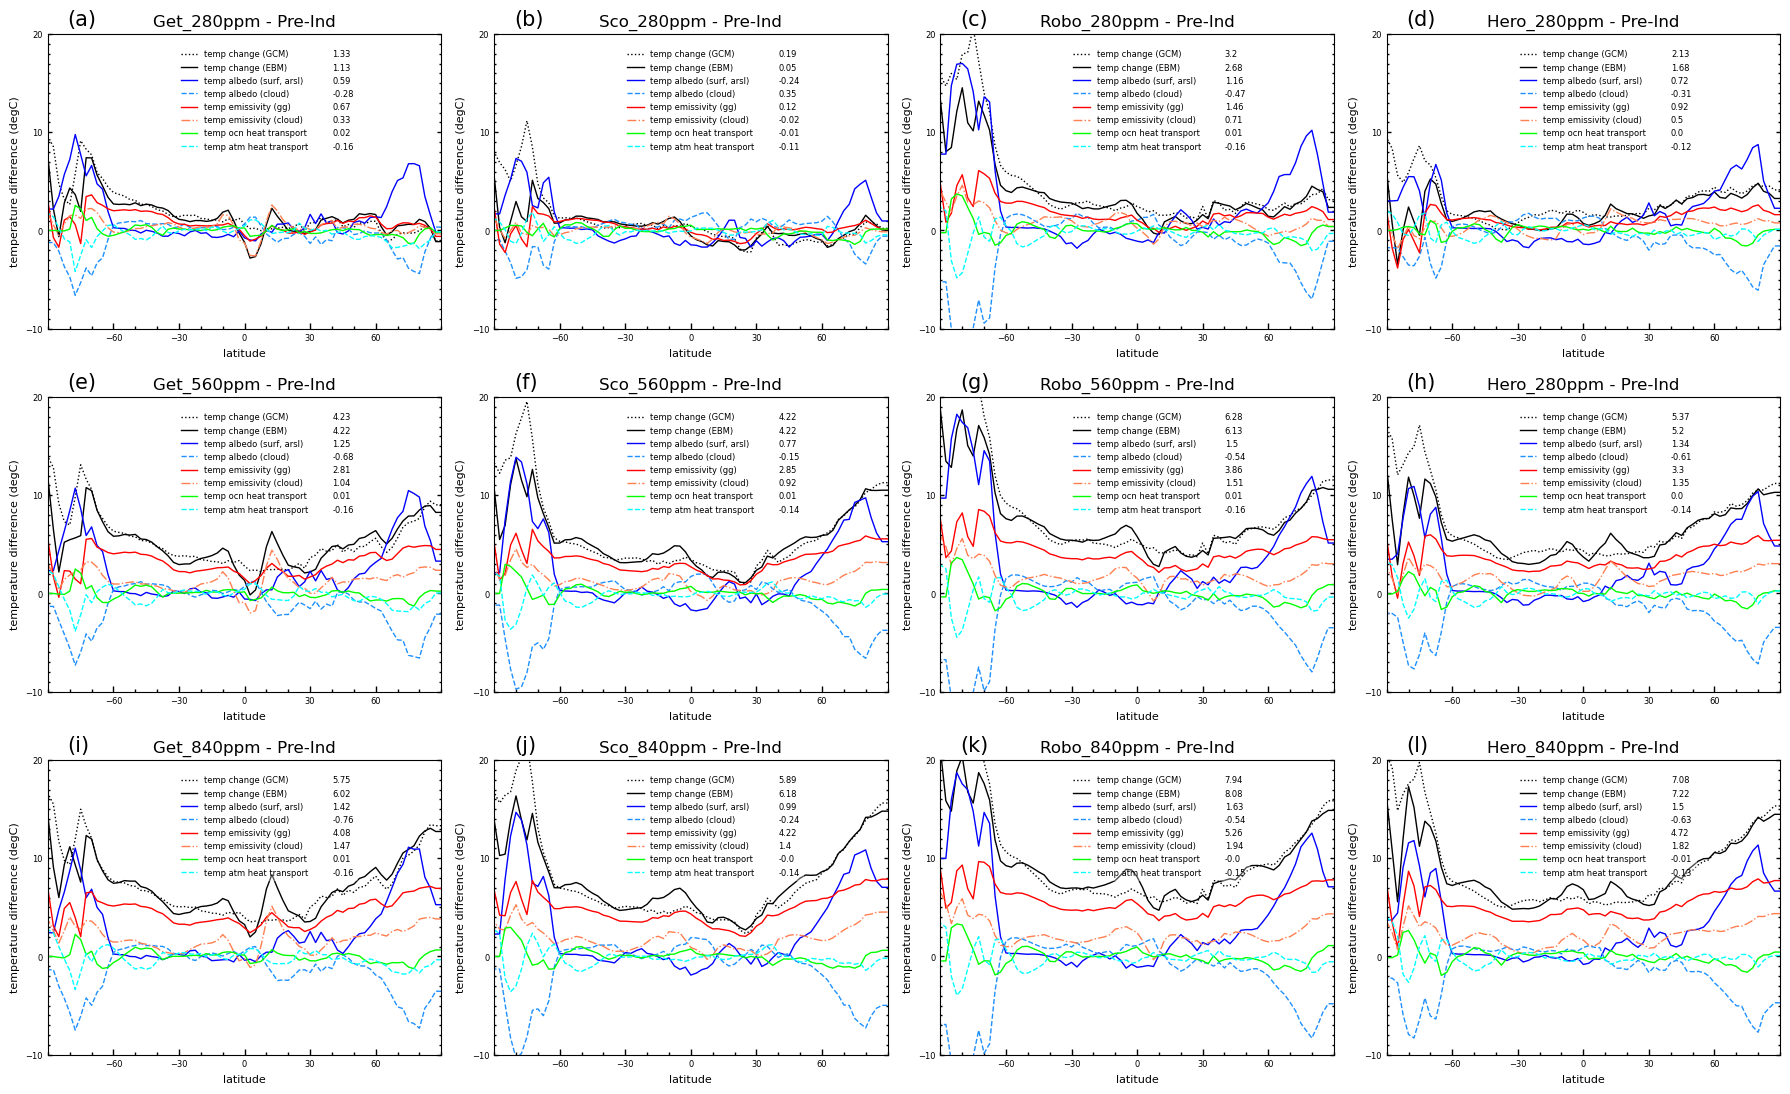

In [77]:
"""
#========================================================================================================
# Convert the outputs to an xlsx file.
#========================================================================================================
dict_out = {}
lst_zones = ['global', 'llat', 'hnlat', 'hslat', 'mlat']
ds_tdezb1 = ebm_dict['tdezb1']
for i in DataArray:
    if i!='tdezb1':
        ds_i = ds_tdezb1[i]
        for j in range(len(lst_zones)):
            dict_out[(i,lst_zones[j])] = {}
        for p in range(len(make_mapplots)):
            if make_mapplots[p]:
                dict_out[(i,lst_zones[0])][ebmvar_name[p]] = ma.sum(ds_i[ebmvarlpw_name[p]])
                dict_out[(i,lst_zones[1])][ebmvar_name[p]] = ma.sum(ds_i[ebmvarllpw_name[p]])
                dict_out[(i,lst_zones[2])][ebmvar_name[p]] = ma.sum(ds_i[ebmvarhnlpw_name[p]])
                dict_out[(i,lst_zones[3])][ebmvar_name[p]] = ma.sum(ds_i[ebmvarhslpw_name[p]])
                dict_out[(i,lst_zones[4])][ebmvar_name[p]] = dict_out[(i,lst_zones[0])][ebmvar_name[p]]-\
                    dict_out[(i,lst_zones[1])][ebmvar_name[p]]-dict_out[(i,lst_zones[2])][ebmvar_name[p]]-\
                    dict_out[(i,lst_zones[3])][ebmvar_name[p]]
df_output = pd.DataFrame.from_dict(dict_out)
#df_output.to_excel('/home/bridge/nd20983/plots/EBM/EBM-PI_data.xlsx')
#with pd.ExcelWriter('/home/bridge/nd20983/plots/EBM/EBM-PI_data.xlsx') as writer:
#    df.to_excel(writer, sheet_name='sheet1')
#    df2.to_excel(writer, sheet_name='sheet2')
"""
#========================================================================================================
# Now make the plots!
#========================================================================================================
# define plotting styles
# color schemes and linestyle and linewidth used here is the best!
#colors_plot = ['green', 'k', 'k', 'blue', 'orange', 'k', 'k', 'r', 'cyan']
colors_plot = ['k', 'k', None, None, None, None, None, 'blue', 'dodgerblue', 'blue', 'dodgerblue', 'r', 'coral', 'lime', 'aqua',]
linestyle_list = ['dotted', 'solid', None, None, None, None, None, 'solid', 'dashed', 'solid', 'dashed', 'solid', 'dashdot', 'solid', 'dashed']
linewidth_list = [1.0, 1.0, None, None, None, None, None, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# Plotting
for m in range(1):
    fignameano = DataArray[m+12]
    figano = plt.figure(num=fignameano, figsize=(18, 12))
    #colors_plot = ['k', 'green', 'k', 'blue', 'purple', 'k', 'k', 'r', 'cyan']
    for mm in range(nsims):
        if mm != m+12 and mm<12:
        #if mm==2:
            ax = figano.add_subplot(3, 4, mm+1)
            #ax = figano.add_subplot(1,1,1)
            textslpw, textsllpw, textshnlpw, textshslpw, textsmlpw = [], [], [], [], []
            for p in range(len(make_mapplots)):
                if make_mapplots[p]:
                    var_plots[p] = ax.plot(ebm_dict[DataArray[m+12]]['zmlats'], ebm_dict[DataArray[m+12]][DataArray[mm]][ebmvar_name[p]],
                                           label=ebmvar_name[p], color=colors_plot[p], linewidth=linewidth_list[p], linestyle=linestyle_list[p])
                    textslpw.append(ma.sum(ebm_dict[DataArray[m+12]][DataArray[mm]][ebmvarlpw_name[p]]))
                    textsllpw.append(ma.sum(ebm_dict[DataArray[m+12]][DataArray[mm]][ebmvarllpw_name[p]]))
                    textshnlpw.append(ma.sum(ebm_dict[DataArray[m+12]][DataArray[mm]][ebmvarhnlpw_name[p]]))
                    textshslpw.append(ma.sum(ebm_dict[DataArray[m+12]][DataArray[mm]][ebmvarhslpw_name[p]]))
                else:
                    pass
            textslpw_ = np.round(textslpw, decimals=2)
            textsllpw_ = np.round(textsllpw, decimals=2)
            textshnlpw_ = np.round(textshnlpw, decimals=2)
            textshslpw_ = np.round(textshslpw, decimals=2)
            textsmlpw_ = np.round(textslpw_-textsllpw_-textshnlpw_-textshslpw_, decimals=2)
            #ax.set_title(DataArray[mm]+'-'+DataArray[m+12]+' EBM')
            ax.set_title(co2_name[mm]+' - '+'Pre-Ind')
            ax.set_xlabel('latitude', fontsize=8)
            ax.set_ylabel('temperature difference (degC)', fontsize=8)
            ax.text(0.05, 1.03, "".join([f"({char})" for char in string.ascii_lowercase[mm]]), transform=ax.transAxes, size=15, weight='normal')
            ax.set_xlim(-90, 90)
            ax.set_ylim(-10, 20)
            ax.set_xticks([-60, -30, 0, 30, 60])
            ax.xaxis.set_minor_locator(MultipleLocator(10))
            ax.yaxis.set_major_locator(MultipleLocator(10))
            ax.yaxis.set_minor_locator(MultipleLocator(1))
            ax.tick_params(axis='x', which='major', direction='in', right=True, length=4, width=1, labelsize=6)
            ax.tick_params(axis='x', which='minor', direction='in', right=True, length=2, width=1, labelsize=6)
            ax.tick_params(axis='y', which='major', direction='in', right=True, length=3, width=1, labelsize=6)
            ax.tick_params(axis='y', which='minor', direction='in', right=True, length=1.5, width=1, labelsize=6)
            legend = ax.legend(loc='center', bbox_to_anchor=(0.3, 0.6, 0.4, 0.35), edgecolor='w', fontsize=6, framealpha=0.3)
            ax.add_artist(legend)
            legend1 = ax.legend(loc='center', handlelength=0, handletextpad=0, bbox_to_anchor=(0.7, 0.6, 0.1, 0.35),
                        edgecolor='w', labels=textslpw_, fontsize=6, framealpha=0.3)
#            ax.add_artist(legend1)
#            legend2 = ax.legend(loc='center', handlelength=0, handletextpad=0, bbox_to_anchor=(0.6, 0.6, 0.1, 0.35),
#                        edgecolor='w', labels=textsllpw_, fontsize=6)
#            ax.add_artist(legend2)
#            legend3 = ax.legend(loc='center', handlelength=0, handletextpad=0, bbox_to_anchor=(0.7, 0.6, 0.1, 0.35),
#                        edgecolor='w', labels=textshnlpw_, fontsize=6)
#            ax.add_artist(legend3)
#            legend4 = ax.legend(loc='center', handlelength=0, handletextpad=0, bbox_to_anchor=(0.8, 0.6, 0.1, 0.35),
#                        edgecolor='w', labels=textshslpw_, fontsize=6)
#            ax.add_artist(legend4)
#            legend5 = ax.legend(loc='center', handlelength=0, handletextpad=0, bbox_to_anchor=(0.9, 0.6, 0.1, 0.35),
#                        edgecolor='w', labels=textsmlpw_, fontsize=6)
        else:
            pass
    #suptitle = plt.suptitle('EBM'+'_expts-'+DataArray[m+12], y=1.02, fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    #figano.savefig('/home/bridge/nd20983/plot/EBM/test/EBM_'+'expts-'+DataArray[m]+'.eps', format='eps', dpi=1200)
    #figano.savefig('/home/bridge/nd20983/plots/EBM/EBM_'+'expts-'+DataArray[m+12]+'plus.png', format='png', dpi=800)
    #figano.savefig('C:/Users/nd20983/docs/Paper/topo_global_climate/figures_material/EBM_expt-PI_new.png', format='png', dpi=800)